# Methoden & Technieken

## Auto-Encoders

8 Dec 2022

Deze slides zijn gebaseerd op
- Hoofdstuk 7 van *Hands on unsupervised learning in Python* van Patel, en
- Hoofdstuk 12 van *Deep learning with Python* van Chollet

### Inhoud

- PCA
- Auto Encoders

In [1]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
X = np.random.multivariate_normal([0,0],[[1,0.9],[0.9,1]], size = 100)

Een principal component analyse (PCA) probeert data te benaderen door het te projecteren op een lager dimensionale lineaire deelruimte.

In [3]:
pca = PCA(n_components=1).fit(X)
p = pca.transform(X)
Xnew = pca.inverse_transform(p)

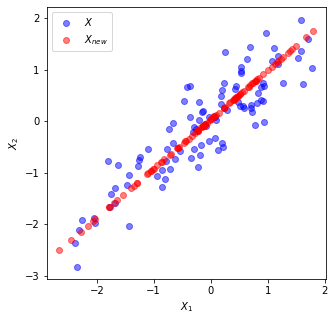

In [4]:
plt.figure(figsize = (5,5))
plt.plot(X[:,0], X[:,1], 'bo', alpha = 0.5, label = '$X$')
plt.plot(Xnew[:,0], Xnew[:,1], 'ro', alpha = 0.5, label = '$X_{new}$')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend()
plt.show()

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape((60000,-1)).astype("float32") / 255
x_test = x_test.reshape((10000,-1)).astype("float32") / 255

pca = PCA(n_components=16).fit(x_train)
p = pca.transform(x_train)


PCA is een unsupervised techniek, hieronder hebben we een PCA gefit op de MNIST data, de labels zijn niet meegenomen in de PCA, toch als we deze labels achteraf inkleuren zien we dat op de eerste twee PC's deze klasses al redelijk gescheiden worden.

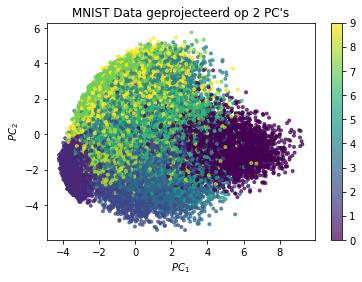

In [6]:
plt.scatter(p[:,0], p[:,1], c = y_train, marker='.', alpha = 0.7)
plt.colorbar()
plt.xlabel('$PC_1$')
plt.ylabel('$PC_2$')
plt.title("MNIST Data geprojecteerd op 2 PC's")
plt.show()

Een PCA van $p$ variabelen naar $q$ componenten is te formuleren als een optimalisatieprobleem. Als ${\bf X}$ een $n \times p$ data matrix is, vind een $p \times q$ matrix ${\bf R}$ zodat

$$
{\bf P} = {\bf X R}, \\
{\bf X}_{new} = {\bf R}^T {\bf P}
$$

en

$$
\text{Reconstruction Error}^2 = \frac{1}{n} \sum_{i=1}^n |\vec{x}_i - \vec{x}_{new,i}|^2
$$

minimaal is.

Omdat 
- lagen (zonder activatie) in een neuraal netwerk matrix vermenigvuldigingen uitvoeren,
- de *reconstruction error* in feite een MSE is,

komt dit neer op het trainen van een netwerk met 
- een *input* laag van grootte $p$,
- een *hidden* laag van grootte $q$,
- een uitvoer laag van grootte $p$. 

Dit netwerk probeert $\vec{x}$ aan de hand van $\vec{x}$ te voorspellen door het door een lager dimensionale laag te voeren.

In [7]:
inputs = keras.Input(shape=(X.shape[1]))
x = layers.Dense(1)(inputs)
outputs = layers.Dense(2)(x)
model = keras.Model(inputs,outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
 dense_1 (Dense)             (None, 2)                 4         
                                                                 


2022-12-08 11:31:13.364930: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.05), loss="mse")

history = model.fit(X,X,epochs=15,batch_size=32)

Epoch 1/15
4/4 [==============================] - 1s 6ms/step - loss: 0.2683
Epoch 2/15
4/4 [==============================] - 0s 11ms/step - loss: 0.1531
Epoch 3/15
4/4 [==============================] - 0s 15ms/step - loss: 0.1219
Epoch 4/15
4/4 [==============================] - 0s 10ms/step - loss: 0.1004
Epoch 5/15
4/4 [==============================] - 0s 4ms/step - loss: 0.0987
Epoch 6/15
4/4 [==============================] - 0s 5ms/step - loss: 0.0891
Epoch 7/15
4/4 [==============================] - 0s 10ms/step - loss: 0.0754
Epoch 8/15
4/4 [==============================] - 0s 10ms/step - loss: 0.0665
Epoch 9/15
4/4 [==============================] - 0s 7ms/step - loss: 0.0628
Epoch 10/15
4/4 [==============================] - 0s 7ms/step - loss: 0.0566
Epoch 11/15
4/4 [==============================] - 0s 6ms/step - loss: 0.0584
Epoch 12/15
4/4 [==============================] - 0s 5ms/step - loss: 0.0556
Epoch 13/15
4/4 [==============================] - 0s 6ms/step - los

Resultaten zijn vrijwel hetzelfde als een PCA.

In [9]:
Xnew = model.predict(X)

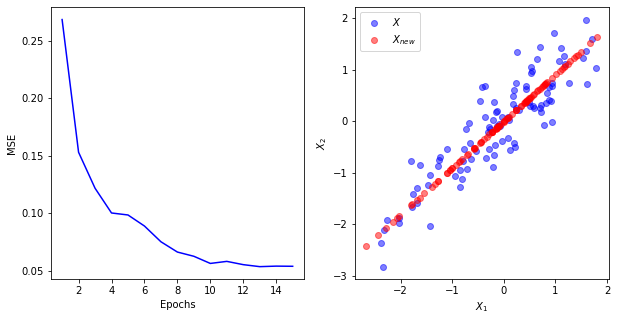

In [10]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(range(1,16), 'loss', 'b-', data = history.history)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.subplot(1,2,2)
plt.plot(X[:,0], X[:,1], 'bo', alpha = 0.5, label = '$X$')
plt.plot(Xnew[:,0], Xnew[:,1], 'ro', alpha = 0.5, label = '$X_{new}$')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend()
plt.show()

Voordeel is dat we nu ook niet-lineaire structuren op zo'n manier kunnen modelleren.

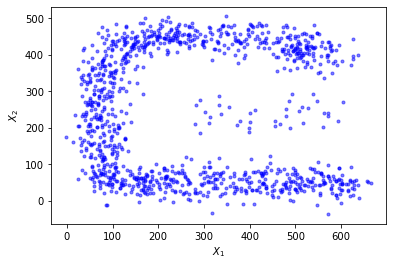

In [11]:
df = pd.read_csv('data_gate.csv').assign(z = lambda d: np.where(d.z == 'a',0,1))
X_train = np.array(df[['x', 'y']])

plt.scatter(x='x', y='y', color='b', marker='.',data=df, alpha = 0.5)
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.show()

In [13]:
tf.random.set_seed(42)

X_scale = StandardScaler().fit_transform(X_train)
model = keras.Sequential([
    layers.Input(shape=(X_scale.shape[1])),
    layers.Dense(3, activation='tanh', use_bias = True),
    layers.Dense(3, activation='tanh',use_bias = True),
    layers.Dense(1, activation='tanh',use_bias = True),
    layers.Dense(3, activation='tanh',use_bias = True),
    layers.Dense(3, activation='tanh',use_bias = True),
    layers.Dense(X_scale.shape[1])
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 3)                 9         
                                                                 
 dense_3 (Dense)             (None, 3)                 12        
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
 dense_5 (Dense)             (None, 3)                 6         
                                                                 
 dense_6 (Dense)             (None, 3)                 12        
                                                                 
 dense_7 (Dense)             (None, 2)                 8         
                                                                 
Total params: 51
Trainable params: 51
Non-trainable para

In [14]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")

In [15]:
history = model.fit(
    X_scale,
    X_scale,
    epochs=200,
    batch_size=8,
    validation_split=0.2,
)

Epoch 1/200
112/112 [==============================] - 1s 5ms/step - loss: 0.8463 - val_loss: 0.5901
Epoch 2/200
112/112 [==============================] - 0s 3ms/step - loss: 0.5718 - val_loss: 0.5893
Epoch 3/200
112/112 [==============================] - 0s 3ms/step - loss: 0.5136 - val_loss: 0.6209
Epoch 4/200
112/112 [==============================] - 0s 3ms/step - loss: 0.5060 - val_loss: 0.6247
Epoch 5/200
112/112 [==============================] - 0s 3ms/step - loss: 0.5008 - val_loss: 0.6211
Epoch 6/200
112/112 [==============================] - 0s 3ms/step - loss: 0.4968 - val_loss: 0.6152
Epoch 7/200
112/112 [==============================] - 0s 3ms/step - loss: 0.4934 - val_loss: 0.6085
Epoch 8/200
112/112 [==============================] - 0s 3ms/step - loss: 0.4907 - val_loss: 0.6029
Epoch 9/200
112/112 [==============================] - 0s 3ms/step - loss: 0.4884 - val_loss: 0.5995
Epoch 10/200
112/112 [==============================] - 0s 3ms/step - loss: 0.4869 - val_lo

Epoch 161/200
112/112 [==============================] - 0s 3ms/step - loss: 0.0230 - val_loss: 0.3453
Epoch 162/200
112/112 [==============================] - 0s 3ms/step - loss: 0.0237 - val_loss: 0.3479
Epoch 163/200
112/112 [==============================] - 0s 3ms/step - loss: 0.0227 - val_loss: 0.3480
Epoch 164/200
112/112 [==============================] - 0s 3ms/step - loss: 0.0228 - val_loss: 0.3401
Epoch 165/200
112/112 [==============================] - 0s 3ms/step - loss: 0.0226 - val_loss: 0.3492
Epoch 166/200
112/112 [==============================] - 0s 3ms/step - loss: 0.0226 - val_loss: 0.3424
Epoch 167/200
112/112 [==============================] - 0s 3ms/step - loss: 0.0223 - val_loss: 0.3498
Epoch 168/200
112/112 [==============================] - 0s 3ms/step - loss: 0.0225 - val_loss: 0.3448
Epoch 169/200
112/112 [==============================] - 0s 3ms/step - loss: 0.0221 - val_loss: 0.3542
Epoch 170/200
112/112 [==============================] - 0s 3ms/step - lo

In [16]:
Xnew = model.predict(X_scale)

Het model vind de vorm in de data.

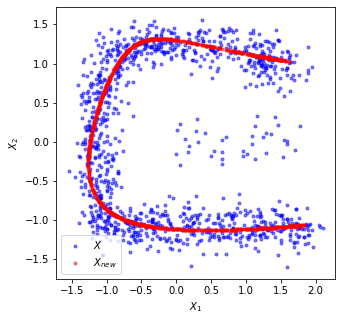

In [17]:
plt.figure(figsize = (5,5))
plt.plot(X_scale[:,0], X_scale[:,1], 'b.', alpha = 0.5, label = '$X$')
plt.plot(Xnew[:,0], Xnew[:,1], 'r.', alpha = 0.5, label = '$X_{new}$')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend()
plt.show()

Een autoencoder bestaat uit twee delen:

- Een encoder, die de invoer transformeert naar een midden laag
- Een decoder, die de midden laag terug transformeert naar de invoer

Wiskundig geformuleerd is de encoder een functie $\vec{h} = f(\vec{x})$ die de invoer $\vec{x} \in \mathbb{R}^p$ transformeert naar $\mathbb{R}^q$. De decoder probeert de encoder te inverteren, en is een functie $\vec{x}_{new} = g(\vec{h})$ die de middenlaag transformeert van $\mathbb{R}^q$ naar $\mathbb{R}^p$.

We noemen de compositie $\vec{x}_{new} = g(f(\vec{x}))$ de *reconstructie* functie.


- Als $q << p$ dan noemen we de autoencoder *undercomplete*. Er zal zeker weten informatie verloren gaan in de reconstructie (en dit willen we vaak juist).
- Als $q >> p$ dan noemen we de autoencoder *overcomplete*. In combinatie met regularisatie (om te zorgen dat het model daadwerkelijk blijft versimpelen) zijn deze modellen vaak  krachtiger, maar moeilijker te trainen. 

Door een willekeurige vector in de midden laag te kiezen en hier de decoder op los te laten kunnen kunstmatige datapunten gegenereerd worden.


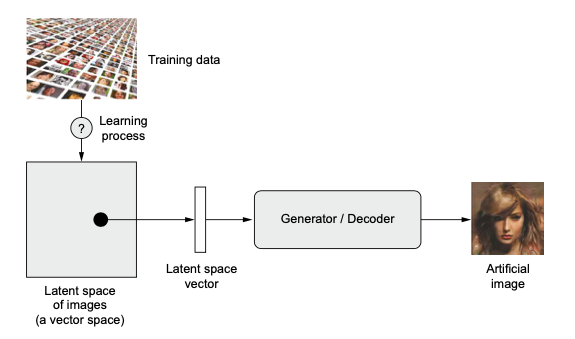

Zo kan men bijvoorbeeld een continu "vlak" van gezichten genereren.

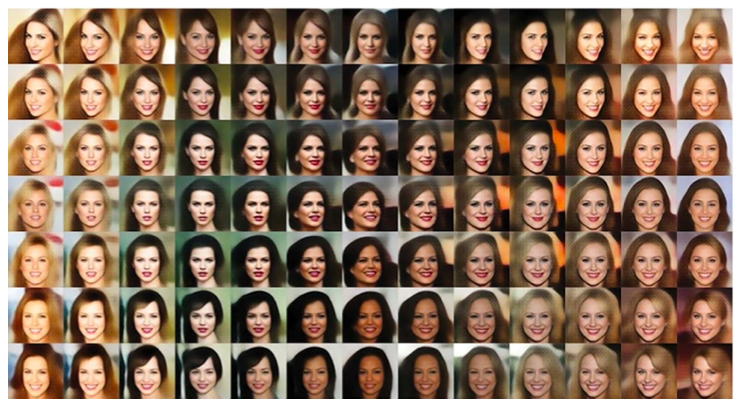

Bepaalde richtingen in de *latent space* komen vaak overeen met bepaalde kenmerken.

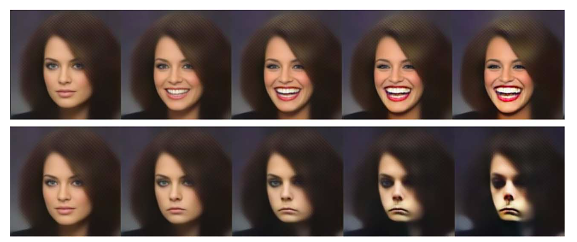